<a href="https://colab.research.google.com/github/RodrigoGuedesDP/IA/blob/main/IA_Fundamentals/practica_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Costo de la solución con Hill Climbing: 756.34937757933
Número de iteraciones de Hill Climbing: 19
Número de evaluaciones de vecinos en Hill Climbing: 554
Tiempo de ejecución de Hill Climbing: 0.0577 segundos
Rutas obtenidas con Hill Climbing:
Vehículo 1 (Capacidad 15): [19, 1, 16, 4, 3, 8]
Vehículo 2 (Capacidad 15): [12, 6, 0, 5, 10]
Vehículo 3 (Capacidad 15): [9, 14, 17, 13, 15]
Vehículo 4 (Capacidad 15): [18, 2, 7, 11]
Vehículo 5 (Capacidad 15): []
Vehículo 6 (Capacidad 15): []
Vehículo 7 (Capacidad 15): []


<ipython-input-7-7c5587d04048>:208: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(rutas))


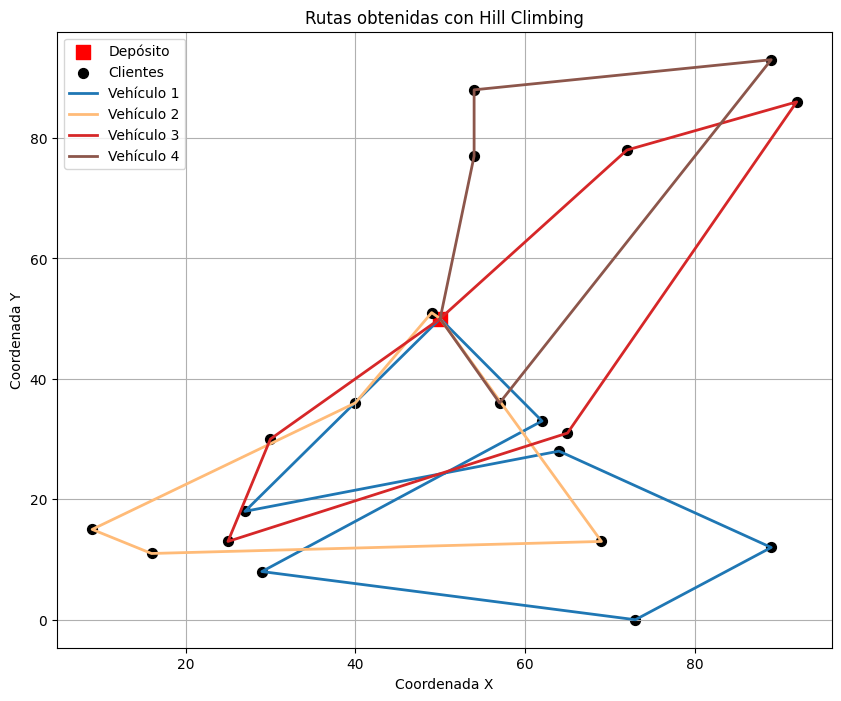


Costo de la solución con Simulated Annealing: 582.0308099592507
Número total de iteraciones de Simulated Annealing: 13500
Número de niveles de temperatura en Simulated Annealing: 135
Tiempo de ejecución de Simulated Annealing: 0.6807 segundos
Rutas obtenidas con Simulated Annealing:
Vehículo 1 (Capacidad 15): []
Vehículo 2 (Capacidad 15): []
Vehículo 3 (Capacidad 15): []
Vehículo 4 (Capacidad 15): [3, 18, 11, 7, 10]
Vehículo 5 (Capacidad 15): [13, 19, 6, 0, 15]
Vehículo 6 (Capacidad 15): [12, 4, 16, 1, 8, 17, 5]
Vehículo 7 (Capacidad 15): [2, 14, 9]


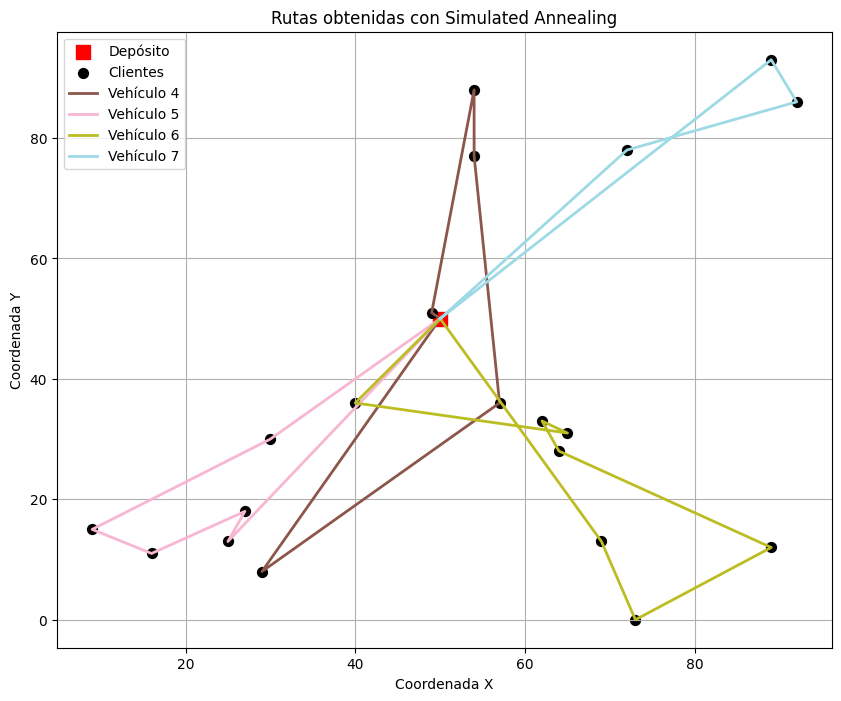

In [ ]:
import random
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import time


# Se realizaran corridas con el numero de clientes para analizar la funcion fitness y el tiempo de ejecucion de cada metodo heuristico implementado.
# Se realizaron corridas con N =10, N = 20, N =30, N =40. Con esto, se analizara la calidad de cada algoritmo cuando aumenta la complejidad.
numero_clientes = 20

# Para simplificar el problema, se mantendra constante La demanda maxima de cada cliente con un valor de 5.
demanda_maxima = 5

# Capacidad de los vehículos (todos iguales para simplificar)
capacidad_vehiculo = 15

# Coordenadas del depósito. Se tomo el caso donde el deposito se encuentra situado simetricamente al medio de los valores maximos de X y Y.
#Como no cambiaremos los valores de X y Y (100 Km) entonces mantendremos la ubicacion del deposito como fija en (50, 50)
deposito = (50, 50)

# Generamos las ubicaciones y las demandas de los clientes de manera aleatoria.Generación de ubicaciones y demandas aleatorias para los clientes.
#Las ubicaciones en el plano X-Y con un valor maximo de 100 Km para cada eje.
np.random.seed(10)
ubicaciones_clientes = np.random.randint(0, 100, size=(numero_clientes, 2))
demandas_clientes = np.random.randint(1, demanda_maxima + 1, size=numero_clientes)

# Utilizaremos esta lista de clientes con un diccionario dentro para guardar el numero de cliente (indice), la demanda de cada uno y su ubicacion en el plano.
clientes = [
    {'indice': i, 'demanda': demandas_clientes[i], 'ubicacion': tuple(ubicaciones_clientes[i])}
    for i in range(numero_clientes)
]



# Si bien es posible considerar un numero muy alto de vehiculos disponibles en la flota para que nunca hagan falta para resolver el problema,
# se va a considerar la siguientes relaciones:

total_demanda_maxima = numero_clientes * demanda_maxima
#es decir, si cada cliente puede tomar una demanda maxima (demanda_maxima), entonces la demanda maxima total es ese valor multiplicado por el numero de clientes.
numero_vehiculos = math.ceil(total_demanda_maxima / capacidad_vehiculo)
#Esta relacion la hemos calculado en base a que la Capacidad total de la flota es igual al numero de vehiculos por la capacidad de los vehiculos, la cual debe ser siempre mayor a N* Demanda maxima.

# cada vehiculo de la flota tendra capacidad igual para simplificar el problema
flota = [{'id_vehiculo': i, 'capacidad': capacidad_vehiculo} for i in range(numero_vehiculos)]

# Crearemos una verificación para ver si la capacidad total de la flota es suficiente (en el caso de que quisieramos cambiar algunos valores del problema)
total_capacidad = numero_vehiculos * capacidad_vehiculo
if total_capacidad < total_demanda_maxima:
    raise ValueError("La capacidad total de la flota es insuficiente para atender la demanda máxima.")


def crear_solucion_inicial(clientes, flota):
    # Crea una solucion inicial considerando las restricciones que hemos puesto
    # Es importante mencionar que para cada solucion se debe atender todas las demandas de los clientes y no se debe exceder la capacidad de los vehiculos.
    rutas = [[] for _ in flota]
    # En esta lista de listas vamos a guardar la ruta que tomara cada vehiculo de la flota.
    capacidad_restante = [vehiculo['capacidad'] for vehiculo in flota]
    # Guardaremos el valor de la capacidad disponible que tiene cada vehiculo.
    # Esta comienza con su capacidad de 15 para todos los casos (capacidad_restante = [15, 15, 15])
    no_visitados = set(c['indice'] for c in clientes)
    lista_clientes = list(no_visitados)
    random.shuffle(lista_clientes)
    # Vamos a asignar aleatoriamente a los clientes a atender.
    for indice_cliente in lista_clientes:
        demanda = clientes[indice_cliente]['demanda']
        asignado = False
        for idx, vehiculo in enumerate(flota):
            if demanda <= capacidad_restante[idx]:
              # Si la capacidad restante del vehiculo puede tomar la demanda del cliente entonces se le asigna esa demanda (utilizamos booleano True)
                rutas[idx].append(indice_cliente)
                capacidad_restante[idx] -= demanda
                #Le restamos el valor de la demanda que tomo del cliente.
                asignado = True
                break
        if not asignado:
            raise ValueError("No es posible asignar al cliente {} sin exceder la capacidad.".format(indice_cliente))
    return rutas


# Para este problema de VRP en base a la capacidad, lo que se optimizara sera la distancia total recorrida por la flota de vehiculos.

def distancia_total(rutas, clientes, deposito):
    total_dist = 0
    for ruta in rutas:
        if ruta:
            ubicacion_anterior = deposito
            for indice_cliente in ruta:
                ubicacion_cliente = clientes[indice_cliente]['ubicacion']
                # Calculamos la distancia euclidiana directamente
                dx = ubicacion_anterior[0] - ubicacion_cliente[0]
                dy = ubicacion_anterior[1] - ubicacion_cliente[1]
                distancia = math.hypot(dx, dy)
                total_dist += distancia
                ubicacion_anterior = ubicacion_cliente
            dx = ubicacion_anterior[0] - deposito[0]
            dy = ubicacion_anterior[1] - deposito[1]
            distancia = math.hypot(dx, dy)
            total_dist += distancia
    return total_dist

def get_neighbors(solution, clientes, flota):
    neighbors = []
    # Guardaremos las soluciones vecinas generadas en la lista neighbors
    num_vehiculos = len(flota)
    for i in range(num_vehiculos):
        for j in range(num_vehiculos):
            if i != j:
              # Para no mover clientes al mismo vehiculo. (si los indices son distintos entonces son vehiculos distintos)
                for a in range(len(solution[i])):
                    # Intentar mover el cliente a de la ruta i a la ruta j
                    new_solution = copy.deepcopy(solution)
                    cliente_a = new_solution[i][a]
                    # Con esto creamos una nueva solucion y obtenemos el cliente a mover.

                    demanda_a = clientes[cliente_a]['demanda']
                    # Esta es la demanda del cliente a mover
                    capacidad_i = flota[i]['capacidad']
                    capacidad_j = flota[j]['capacidad']
                    # Obtenemos las demas de las rutas despues del movimiento.
                    ruta_i_demanda = sum(clientes[c]['demanda'] for c in new_solution[i]) - demanda_a
                    ruta_j_demanda = sum(clientes[c]['demanda'] for c in new_solution[j]) + demanda_a
                    # Aca tenemos que comprobar que la demandas de las rutas no excedan la capacidad del vehiculo, lo cual es la restriccion.
                    if ruta_i_demanda <= capacidad_i and ruta_j_demanda <= capacidad_j:
                        new_solution[i].pop(a)
                        new_solution[j].append(cliente_a)
                        neighbors.append(new_solution)
                        # Movemos al cliente y agregamos la nueva solucion a neighbors.
    return neighbors

def get_random_neighbor(solution, clientes, flota):
    # Generamos una solucion vecina aleatoria para utlizarla en simmulated annealing.
    # Necesitamos esta funcion para evitar caer en los optimos locales en los que Hill Climbing se puede quedar.
    new_solution = copy.deepcopy(solution)
    num_vehiculos = len(flota)
    # Seleccionamos aleatoriamente dos vehiculos distintos
    i, j = random.sample(range(num_vehiculos), 2)
    if solution[i]:
      # Verificamos que la ruta no este vacia
        a = random.randrange(len(solution[i]))
        # Seleccionamos aleatoriamente un cliente de la ruta del vehiculo
        cliente_a = solution[i][a]

        demanda_a = clientes[cliente_a]['demanda']
        capacidad_i = flota[i]['capacidad']
        capacidad_j = flota[j]['capacidad']

        ruta_i_demanda = sum(clientes[c]['demanda'] for c in solution[i]) - demanda_a
        ruta_j_demanda = sum(clientes[c]['demanda'] for c in solution[j]) + demanda_a
        # Igual que en get_neighbors, analizamos la factibilidad de la solucion si no excede las restricciones.
        if ruta_i_demanda <= capacidad_i and ruta_j_demanda <= capacidad_j:
            new_solution[i].pop(a)
            new_solution[j].append(cliente_a)
            return new_solution
    return new_solution


def hill_climbing(clientes, deposito, flota):
    current_solution = crear_solucion_inicial(clientes, flota)
    current_cost = distancia_total(current_solution, clientes, deposito)
    improving = True
    iteration_count = 0
    neighbor_evaluations = 0
    while improving:
        improving = False
        neighbors = get_neighbors(current_solution, clientes, flota)
        iteration_count += 1
        for neighbor in neighbors:
            neighbor_evaluations += 1
            neighbor_cost = distancia_total(neighbor, clientes, deposito)
            if neighbor_cost < current_cost:
                current_solution = neighbor
                current_cost = neighbor_cost
                improving = True
                break
    return current_solution, current_cost, iteration_count, neighbor_evaluations


def simulated_annealing(clientes, deposito, flota, initial_temperature, cooling_rate, iteration_per_temp):
    current_solution = crear_solucion_inicial(clientes, flota)
    current_cost = distancia_total(current_solution, clientes, deposito)
    best_solution = current_solution
    best_cost = current_cost
    T = initial_temperature
    total_iterations = 0
    temperature_steps = 0
    while T > 1:
        temperature_steps += 1
        for _ in range(iteration_per_temp):
            total_iterations += 1
            new_solution = get_random_neighbor(current_solution, clientes, flota)
            new_cost = distancia_total(new_solution, clientes, deposito)
            delta = new_cost - current_cost
            if delta < 0 or random.uniform(0, 1) < math.exp(-delta / T):
                current_solution = new_solution
                current_cost = new_cost
                if current_cost < best_cost:
                    best_solution = current_solution
                    best_cost = current_cost
        T *= cooling_rate
    return best_solution, best_cost, total_iterations, temperature_steps

# Crearemos una funcion para poder plotear las rutas tomadas por cada vehiculo. Utilizaremos colores distintos para diferencias la ruta de cada vehiculo.

def plot_routes(rutas, clientes, deposito, titulo):
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('tab20', len(rutas))

    # Dibujar el depósito
    plt.scatter(deposito[0], deposito[1], c='red', marker='s', s=100, label='Depósito')

    # Dibujar los clientes
    posiciones_clientes = np.array([cliente['ubicacion'] for cliente in clientes])
    plt.scatter(posiciones_clientes[:, 0], posiciones_clientes[:, 1], c='black', marker='o', s=50, label='Clientes')

    # Dibujar las rutas
    for idx, ruta in enumerate(rutas):
        if ruta:
            ruta_coords = [deposito] + [clientes[i]['ubicacion'] for i in ruta] + [deposito]
            xs, ys = zip(*ruta_coords)
            plt.plot(xs, ys, color=colors(idx % 20), linewidth=2, label=f'Vehículo {idx + 1}')

    plt.title(titulo)
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend()
    plt.grid(True)
    plt.show()


# hill climbing
start_time_hc = time.time()
hc_solution, hc_cost, hc_iterations, hc_neighbor_evaluations = hill_climbing(clientes, deposito, flota)
end_time_hc = time.time()
hc_execution_time = end_time_hc - start_time_hc

print("Costo de la solución con Hill Climbing:", hc_cost)
print("Número de iteraciones de Hill Climbing:", hc_iterations)
print("Número de evaluaciones de vecinos en Hill Climbing:", hc_neighbor_evaluations)
print("Tiempo de ejecución de Hill Climbing: {:.4f} segundos".format(hc_execution_time))
print("Rutas obtenidas con Hill Climbing:")
for idx, ruta in enumerate(hc_solution):
    capacidad = flota[idx]['capacidad']
    print(f"Vehículo {idx + 1} (Capacidad {capacidad}): {ruta}")

# Visualizar rutas  con hill climbing:
plot_routes(hc_solution, clientes, deposito, "Rutas obtenidas con Hill Climbing")

#Simulated Annealing
start_time_sa = time.time()
sa_solution, sa_cost, sa_total_iterations, sa_temperature_steps = simulated_annealing(
    clientes,
    deposito,
    flota,
    initial_temperature=1000,
    cooling_rate=0.95,
    iteration_per_temp=100
)
end_time_sa = time.time()
sa_execution_time = end_time_sa - start_time_sa

print("\nCosto de la solución con Simulated Annealing:", sa_cost)
print("Número total de iteraciones de Simulated Annealing:", sa_total_iterations)
print("Número de niveles de temperatura en Simulated Annealing:", sa_temperature_steps)
print("Tiempo de ejecución de Simulated Annealing: {:.4f} segundos".format(sa_execution_time))
print("Rutas obtenidas con Simulated Annealing:")
for idx, ruta in enumerate(sa_solution):
    capacidad = flota[idx]['capacidad']
    print(f"Vehículo {idx + 1} (Capacidad {capacidad}): {ruta}")

# Visualizar rutas con simulated annealing:
plot_routes(sa_solution, clientes, deposito, "Rutas obtenidas con Simulated Annealing")

